# Introduction

I think that everyone is aware of the performance and incredible achievements of this squad from last season. They managed to win three titles: the Champions League, the Emirates FA Cup, and the Premier League. After enormous spending and years of waiting, Pep Guardiola's side finally managed to reach greatness through hard work and dedication. In the following sections, we will see how well they performed, analyzing their statistics from the last Premier League campaign.

This paper will be a walk-around in probability and statistics, summarizing some fundamental concepts of this science. Also, I will use Python to be able to show the results of the calculations, taking advantage of some of its powerful libraries like `SciPy`, `Pandas`, or `Matplotlib`.

# Creating the dataset

Let's start by creating our dataset, which will contain all the results of the fixtures from last season. I got them from [here](https://www.football-data.co.uk/englandm.php).

In [22]:
# Import the libraries we'll need for this analysis

import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Read in the data

df = pd.read_csv('https://www.football-data.co.uk/mmz4281/2223/E0.csv')

# Let's take a look at the first five rows of the data frame to see what we're working with

df.head(5)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,05/08/2022,20:00,Crystal Palace,Arsenal,0,2,A,0,1,...,1.76,0.50,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85
1,E0,06/08/2022,12:30,Fulham,Liverpool,2,2,D,1,0,...,2.73,1.75,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99
2,E0,06/08/2022,15:00,Bournemouth,Aston Villa,2,0,H,1,0,...,1.76,0.50,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00
3,E0,06/08/2022,15:00,Leeds,Wolves,2,1,H,1,1,...,1.87,-0.25,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81
4,E0,06/08/2022,15:00,Newcastle,Nott'm Forest,2,0,H,0,0,...,1.89,-1.00,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86


As we can see, there are a lot of columns that we don't need, for example, the date and time columns or the columns related to betting odds. We will clean and filter our data to only contain the results of the fixtures for Manchester City.

In [23]:
# Let's keep only the columns that we need

df = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]

# Now let's filter the data frame to only contain the fixtures for Man City

df = df[(df['HomeTeam'] == 'Man City') | (df['AwayTeam'] == 'Man City')]

# We can also rename the columns to make them easier to work with

df = df.rename(columns={'HomeTeam': 'Home', 'AwayTeam': 'Away', 'FTHG': 'Home Goals', 'FTAG': 'Away Goals', 'FTR': 'Result'})

# We'll replace the values in the Result column with W, D, and L, representing a win, draw, and loss for Man City respectively

df['Result'] = df.apply(lambda row: 'W' if row['Home'] == 'Man City' and row['Result'] == 'H' 
                        else ('W' if row['Away'] == 'Man City' and row['Result'] == 'A' 
                              else ('D' if row['Result'] == 'D' else 'L')), axis=1)

# Reset the indices and display the first ten rows of the data frame

df = df.reset_index(drop=True)
df.index += 1
df.head(10)

,Home,Away,Home Goals,Away Goals,Result
1,West Ham,Man City,0,2,W
2,Man City,Bournemouth,4,0,W
3,Newcastle,Man City,3,3,D
4,Man City,Crystal Palace,4,2,W
5,Man City,Nott'm Forest,6,0,W
6,Aston Villa,Man City,1,1,D
7,Wolves,Man City,0,3,W
8,Man City,Man United,6,3,W
9,Man City,Southampton,4,0,W
10,Liverpool,Man City,1,0,L


We can now observe that our data is presented in a cleaner manner. As a result, we can begin to analyze it.

# Basic statistics

Let's start with simple stuff, like counting the number of wins, draws, or defeats, finding the number of goals scored and conceded in the entire season, the maximum number of goals scored in a single match, etc.

In [24]:
# Count the number of wins, draws and defeats

wins = df['Result'].value_counts()['W']
draws = df['Result'].value_counts()['D']
defeats = df['Result'].value_counts()['L']

print(f'Wins: {wins}, Draws: {draws}, Defeats: {defeats}')

# Find the total number of goals scored and conceded

goals_scored = df.loc[df['Home'] == 'Man City', 'Home Goals'].sum() + df.loc[df['Away'] == 'Man City', 'Away Goals'].sum()
goals_conceded = df.loc[df['Home'] == 'Man City', 'Away Goals'].sum() + df.loc[df['Away'] == 'Man City', 'Home Goals'].sum()

print(f'Goals Scored: {goals_scored}, Goals Conceded: {goals_conceded}, Goal Difference: {goals_scored - goals_conceded}')

# Calculate the maximum number of goals scored in a single match
max_home_goals = df.loc[df['Home'] == 'Man City', 'Home Goals'].max()
max_away_goals = df.loc[df['Away'] == 'Man City', 'Away Goals'].max()

max_goals = max(max_home_goals, max_away_goals)

print(f'Max goals scored in a single game: {max_goals}')

# Display the teams that managed to defeat Man City

teams = pd.concat([df.loc[df['Result'] == 'L', 'Home'], df.loc[df['Result'] == 'L', 'Away']]).unique()
teams = [team for team in teams if team != 'Man City']

print(f'Teams that managed to defeat Man City: {", ".join(teams)}')

Wins: 28, Draws: 5, Defeats: 5
Goals Scored: 94, Goals Conceded: 33, Goal Difference: 61
Max goals scored in a single game: 6
Teams that managed to defeat Man City: Liverpool, Man United, Tottenham, Brentford


As we can see, Manchester City had impressive stats, managing to score 94 goals in 38 matches and only losing on five occasions. Further, we'll continue our analysis with a more complex approach of their performance.

## Advanced analysis

At the beginning, let's see how many goals they scored in each round. This quantity is a random variable that follows a `Poisson` distribution, which is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space, in our case, the number of goals scored in each match.

In [25]:
# Let's create a new data frame to display the opponent, goals scored and result of each round

rounds_df = pd.DataFrame(columns=['Opponent', 'Goals Scored', 'Result'])
rounds_df['Opponent'] = pd.concat([df.loc[df['Home'] == 'Man City', 'Away'], df.loc[df['Away'] == 'Man City', 'Home']]).sort_index()
rounds_df['Goals Scored'] = pd.concat([df.loc[df['Home'] == 'Man City', 'Home Goals'], df.loc[df['Away'] == 'Man City', 'Away Goals']])
rounds_df['Result'] = df['Result']

rounds_df.index.name = 'Round'
rounds_df

,Opponent,Goals Scored,Result
Round,,,
1,West Ham,2,W
2,Bournemouth,4,W
3,Newcastle,3,D
4,Crystal Palace,4,W
5,Nott'm Forest,6,W
6,Aston Villa,1,D
7,Wolves,3,W
8,Man United,6,W
9,Southampton,4,W


To estimate the parameter $\lambda$ of the Poisson distribution, we'll use the **Maximum likelihood estimation**. The function $V(\lambda) = f_{(X_1, X_2, ..., X_n)} (x_1, x_2, .., x_n; \lambda)$, where $x_1, x_2, ..., x_n$ are the results of a selection of n random variables is called the **likelihood function**. We'll need to find the value of $\lambda$ which maximizes the likelihood function: $\lambda = argmax \, V(\lambda)$. In practice, it is more convenient to work with the natural logarithm of the likelihood function since the logarithm is a monotonic function, which means that the maximum occurs at the same value of $\lambda$. Since the random variables $X_1, X_2, ..., X_n$ are independent and identically distributed, we can write the likelihood function as: $$V(\lambda) = \prod_{k = 1}^n f (x_k; \lambda)$$ where $f(x_k; \lambda)$ is the probability mass function of the Poisson distribution: $f(x; \lambda) = P(X=x) = \frac{\lambda^x \, e^{-\lambda}}{x!}$. Plugging in the values of $x_1, x_2,..., x_n$ which represent the number of goals scored in each round from the table above, we obtain: $$V(\lambda) = \frac{\lambda^2 \, e^{-\lambda}}{2!} \cdot \frac{\lambda^4 \, e^{-\lambda}}{4!} \cdot \frac{\lambda^3 \, e^{-\lambda}}{3!} \cdot ... \cdot \frac{\lambda^1 \, e^{-\lambda}}{1!} \cdot \frac{\lambda^0 \, e^{-\lambda}}{0!} = \frac{\lambda^{(2 + 4 + 3 + ... + 1 + 0)} \cdot e^{-38\lambda}}{2! \cdot 4! \cdot 3! \cdot ... \cdot 1! \cdot 0!}$$Since we earlier calculated the number of goals scored by Manchester City in the entire season, we know that the exponent of $\lambda$ is equal to 94. Applying the natural logarithm to the likelihood function gives the following result: $$\ln(V(\lambda)) =  \ln(\frac{\lambda^{94} \cdot e^{-38\lambda}}{2! \cdot 4! \cdot 3! \cdot ... \cdot 1! \cdot 0!}) = \ln(\lambda^{94} \cdot e^{-38\lambda}) - \ln(2! \cdot 4! \cdot 3! \cdot ... \cdot 1! \cdot 0!) = 94\ln(\lambda) - 38 \lambda - \ln(2! \cdot 4! \cdot 3! \cdot ... \cdot 1! \cdot 0!)$$To find the value of $\lambda$ that maximizes this function, we take the first derivative of the natural logarithm of the likelihood function and solve the following equation: $\frac{d}{d\lambda}\ln(V(\lambda)) = 0$. $$\frac{d}{d\lambda}\ln(V(\lambda)) = \frac{94}{\lambda} - 38 = 0, \, \lambda = \frac{94}{38} = 2.474$$ Now, to make sure that $\lambda = 2.474$ is a maximum, we take the second derivative of the likelihood function and test if it is less than zero: $$\frac{d^2}{d\lambda^2}\ln(V(\lambda)) = -\frac{94}{\lambda^2} < 0, \, \forall \lambda$$Finally, using the **Maximum likelihood estimation**, we calculated that our parameter $\lambda$ is equal to **2.474**, which means that Manchester City scored on average 2.474 goals per match. Now, let's plot the probability mass function and interpret the result.

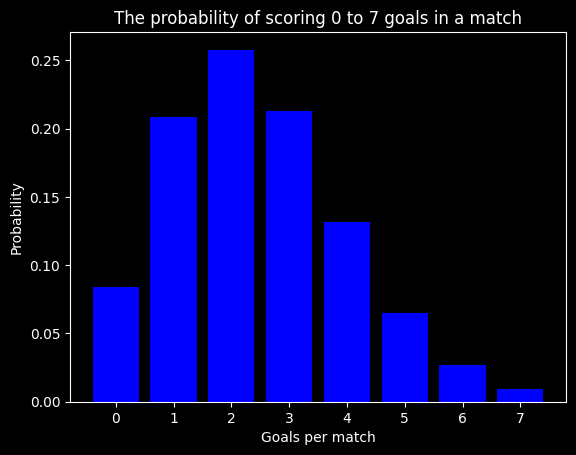

In [26]:
# Generate the x values for the probability mass function and plot it

x = range(8)

plt.style.use('dark_background')
plt.bar(x, stats.poisson.pmf(x, 2.474), align='center', color='blue')
plt.xlabel('Goals per match')
plt.ylabel('Probability')
plt.title('The probability of scoring 0 to 7 goals in a match')
plt.show()

In the graph above, we can observe the probability of scoring exactly k goals in a match on the y axis, where k represents the values from 0 to 7. The graph ends at 7 goals in a match because for 8 goals or greater, the probability is very small (P($k = 8$ goals in a match) = 0.0029). Also, it is obvious that the probability of scoring less than five goals in a match is very high: P($k < 5$ goals in a match) = P($k \leq 4$ goals in a match) = P($k = 0$ goals in a match) + P($k = 1$ goal in a match) + ... + P($k = 4$ goals in a match) = 0.895, so the chance of scoring less than 5 goals in a game (or the chance of scoring a maximum of 4 goals in a game) is ~90%. Now, to verify that our hypotesis is correct, we can use a statistic test for goodness of fit, like the $\chi^2$ test. First, let's calculate the observed frequency and the expected frequency of goals scored.

In [27]:
# Create a new data frame that stores the number of goals scored and the observed frequency (number of times that number of goals was scored)

goals_df = pd.DataFrame(columns=['Observed Freq'])
goals_df['Observed Freq'] = rounds_df['Goals Scored'].value_counts()
goals_df.loc[5] = 0
goals_df.sort_index(inplace=True)
goals_df.index.name = 'Scored'

# Calculate the expected frequency for each number of goals scored

expected_goals = [stats.poisson.pmf(i, 2.474) * goals_df['Observed Freq'].sum() for i in range(7)]
goals_df['Expected Freq'] = expected_goals

# Display the data frame
goals_df

,Observed Freq,Expected Freq
Scored,,
0,3,3.201393
1,10,7.920247
2,5,9.797346
3,10,8.079545
4,8,4.997198
5,0,2.472614
6,2,1.019541


The observed frequency is, in our case, the number of times Manchester City scored k goals in a match. The expected frequency is the number of times we expect an event to occur, in our case, the number of times we expect Manchester City to score k goals in a match. The expected frequency is calculated using the probability mass function of the Poisson distribution: $f(x; \lambda) = P(X=x) = \frac{\lambda^x \, e^{-\lambda}}{x!}$. Now, let's calculate the $\chi^2_o$ statistic. First, we need to make sure that all expected frequencies are greater than or equal to five, so we'll combine the first two and the last three.

In [28]:
# Combine the last three rows into a single row

goals_df.loc[1] += goals_df.loc[0]
goals_df.loc[4] += goals_df.loc[5] + goals_df.loc[6]

# Drop the first row and last two rows

goals_df.drop([0, 5, 6], inplace=True)
goals_df.rename(index={1:'1 or less', 4: '4 or more'}, inplace=True)
goals_df

,Observed Freq,Expected Freq
Scored,,
1 or less,13,11.121641
2,5,9.797346
3,10,8.079545
4 or more,10,8.489353


To calculate $\chi^2_o$, we use the following formula: $$\chi^2_o = \sum_{i = 1}^n \frac{(O_i - E_i)^2}{E_i}$$ where $O_i$ is the observed frequency and $E_i$ is the expected frequency. Further, we need to calculate the critical value. We'll chose a significance level of 0.01, or 1%. Since we have 4 categories and we estimated the parameter $\lambda$, the degrees of freedom are $4 - 1 - 1 = 2$. To calculate the critical value $\chi^2_{0.01, 2}$, we can use the `scipy.stats` library. The null and alternative hypotheses are: $$H_0: \text{The data fits the Poisson distribution}$$ $$H_1: \text{The data does not fit the Poisson distribution}$$ If $\chi^2_o < \chi^2_{0.01, 2}$, we accept the null hypothesis, otherwise we reject it.

In [29]:
# Calculate the chi-squared statistic

chi_o_squared = (((goals_df['Observed Freq'] - goals_df['Expected Freq'])**2) / goals_df['Expected Freq']).sum()

# Calculate the critical value

critical_value = stats.chi2.ppf(q=0.99, df=2)

# Display the results

print(f'Calculated value: {round(chi_o_squared, 3)}')
print(f'Critical value: {round(critical_value, 3)}')

if chi_o_squared < critical_value:
    print('The null hypothesis is accepted, the data fits the distribution.')
else:
    print('The null hypothesis is rejected, the data does not fit the distribution.')

Calculated value: 3.392
Critical value: 9.21
The null hypothesis is accepted, the data fits the distribution.


As we can see, the null hypothesis is accepted, so we can conclude that the data fits the Poisson distribution with 99% confidence. Hence, our assumption that the number of goals scored in a match follows a Poisson distribution is correct.

## Conclusions

Finally, we analyzed the impressive performance of Manchester City in the 2022-2023 Premier League campaign. We started by creating a dataset containing all the results of the fixtures from last season. Then, we calculated some basic statistics like the number of wins, draws, or defeats, the number of goals scored and conceded in the entire season, the maximum number of goals scored in a single match, etc. Further, we analyzed the number of goals scored in each round, finding that this quantity is a random variable that follows a Poisson distribution. We estimated the parameter $\lambda$ of the Poisson distribution using the Maximum likelihood estimation. In the end, we used a statistic test for goodness of fit, the $\chi^2$ test, to verify that our assumption is correct and we concluded that the data fits the Poisson distribution with 99% confidence.

It's clear now that Manchester City had an incredible performance last season, managing to impress everyone with their style of play and their results. I hope that you find this paper interesting and that you learned something new about probability and statistics, seeing how they can be applied in real life.